# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
# %pip install umap
# %pip install umap-learn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [2]:
base_path = '/Users/ignacio/MAESTRIA/DMEF/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'

In [3]:
df_train = pd.read_csv(dataset_path + dataset_file)

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [4]:
df_train = df_train[df_train['foto_mes']==202104]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [5]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [6]:
np.random.seed(261823)
continua_sample = ytrain[ytrain == 0].sample(4000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [7]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')     
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

model = RandomForestClassifier(n_estimators=10000, max_features='sqrt', min_samples_leaf=400, max_depth=15, random_state=42 )
model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_depth=15, min_samples_leaf=400, n_estimators=10000,
                       random_state=42)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [8]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [9]:
md


array([[0.    , 0.9327, 0.6599, ..., 0.9424, 0.8598, 0.577 ],
       [0.9327, 0.    , 0.7951, ..., 0.8869, 0.8572, 0.8862],
       [0.6599, 0.7951, 0.    , ..., 0.7902, 0.8634, 0.5746],
       ...,
       [0.9424, 0.8869, 0.7902, ..., 0.    , 0.9372, 0.9167],
       [0.8598, 0.8572, 0.8634, ..., 0.9372, 0.    , 0.9225],
       [0.577 , 0.8862, 0.5746, ..., 0.9167, 0.9225, 0.    ]])

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


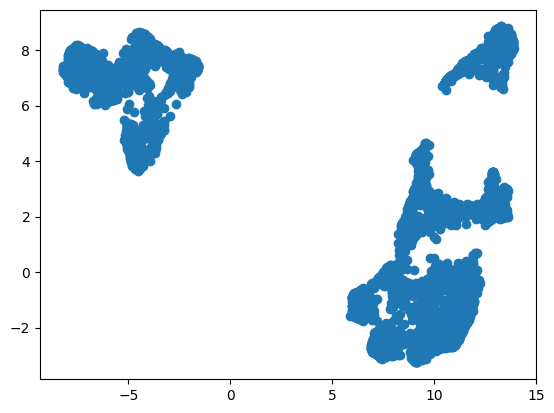

In [10]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
  random_state=42,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

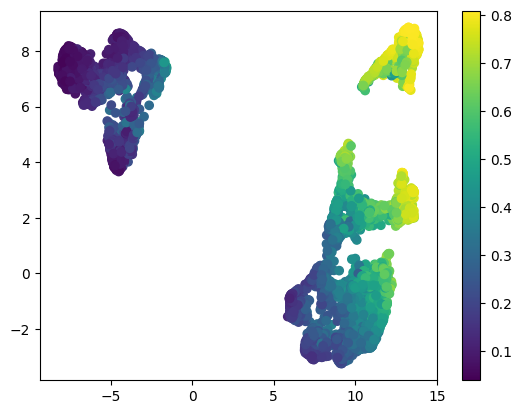

In [11]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

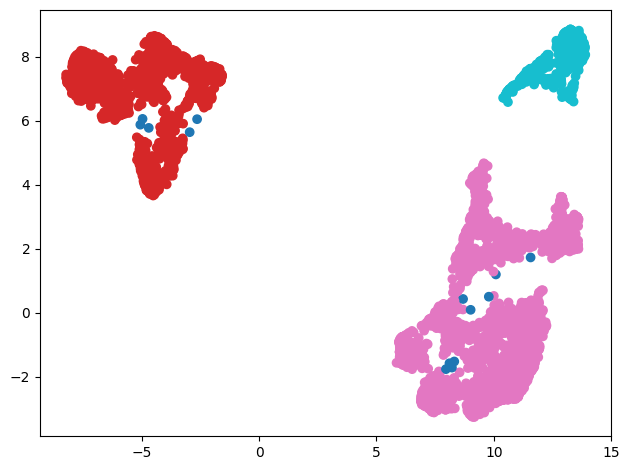

In [12]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
plt.tight_layout()
plt.show()

Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

In [13]:
pd.Series(y.labels_).value_counts()

 1    3228
 0    2239
 2     690
-1      14
Name: count, dtype: int64

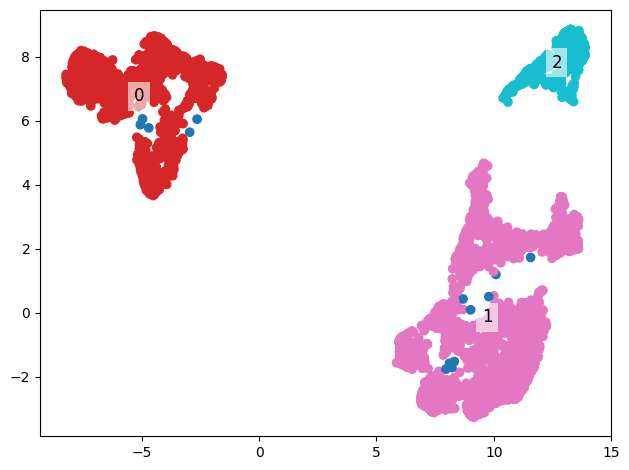

In [14]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')

# Annotate clusters with numbers
for cluster in np.unique(y.labels_):
    if cluster != -1:  # Skip outliers
        cluster_points = embedding_rf[y.labels_ == cluster]
        cluster_center = cluster_points.mean(axis=0)
        plt.text(cluster_center[0], cluster_center[1], str(cluster), fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout()
plt.show()

Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

In [15]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=42)
  model.fit(Xtrain_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Y exploramos cuales son las variables importantes por cada cluster

In [16]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")


Cluster 0 vs. Resto:
  - cpayroll_trx
  - mpayroll
  - mcomisiones_mantenimiento
  - ccomisiones_mantenimiento
  - ctarjeta_debito_transacciones
Cluster 1 vs. Resto:
  - mpayroll
  - cpayroll_trx
  - mcomisiones_mantenimiento
  - ctarjeta_visa
  - ccomisiones_mantenimiento
Cluster 2 vs. Resto:
  - ctarjeta_visa
  - cproductos
  - ctarjeta_master
  - mcaja_ahorro
  - ctrx_quarter
Cluster -1 vs. Resto:
  - mpasivos_margen
  - Visa_mpagospesos
  - mpagomiscuentas
  - Visa_Fvencimiento
  - Visa_mconsumospesos


Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda



Analysis for Cluster 0

Feature: cpayroll_trx


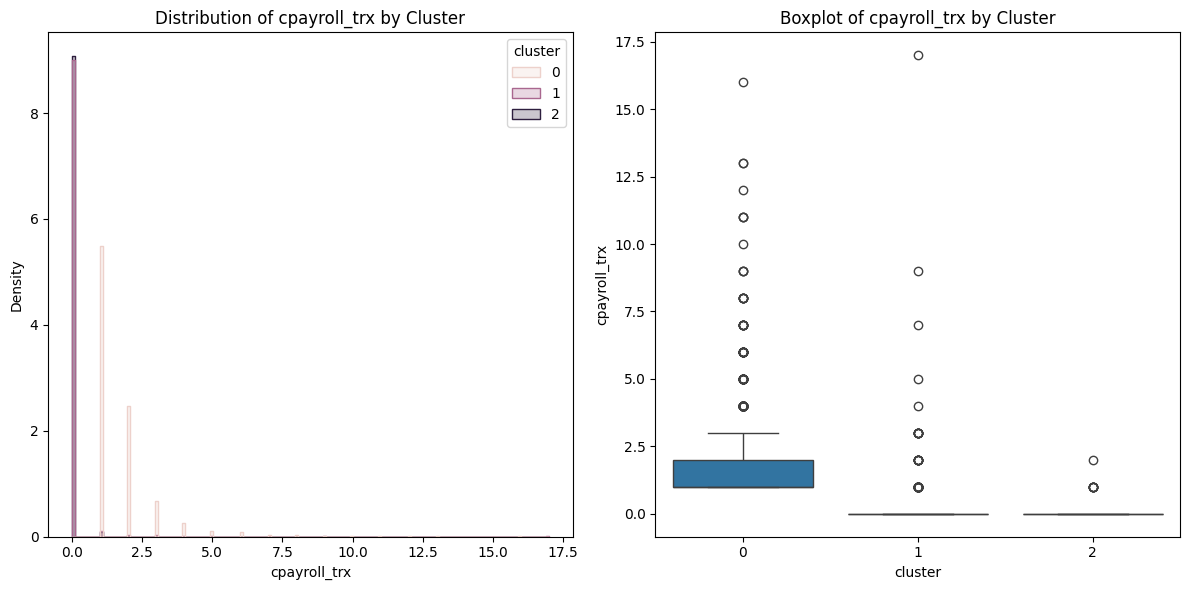

          count      mean       std  min  25%  50%  75%   max
cluster                                                      
0        2239.0  1.683341  1.249573  1.0  1.0  1.0  2.0  16.0
1        3228.0  0.037794  0.431696  0.0  0.0  0.0  0.0  17.0
2         690.0  0.013043  0.125677  0.0  0.0  0.0  0.0   2.0

Correlation with other top features:
cpayroll_trx                     1.000000
mpayroll                         0.346009
ctarjeta_debito_transacciones    0.288346
mcomisiones_mantenimiento       -0.332041
ccomisiones_mantenimiento       -0.417859
Name: cpayroll_trx, dtype: float64

Feature: mpayroll


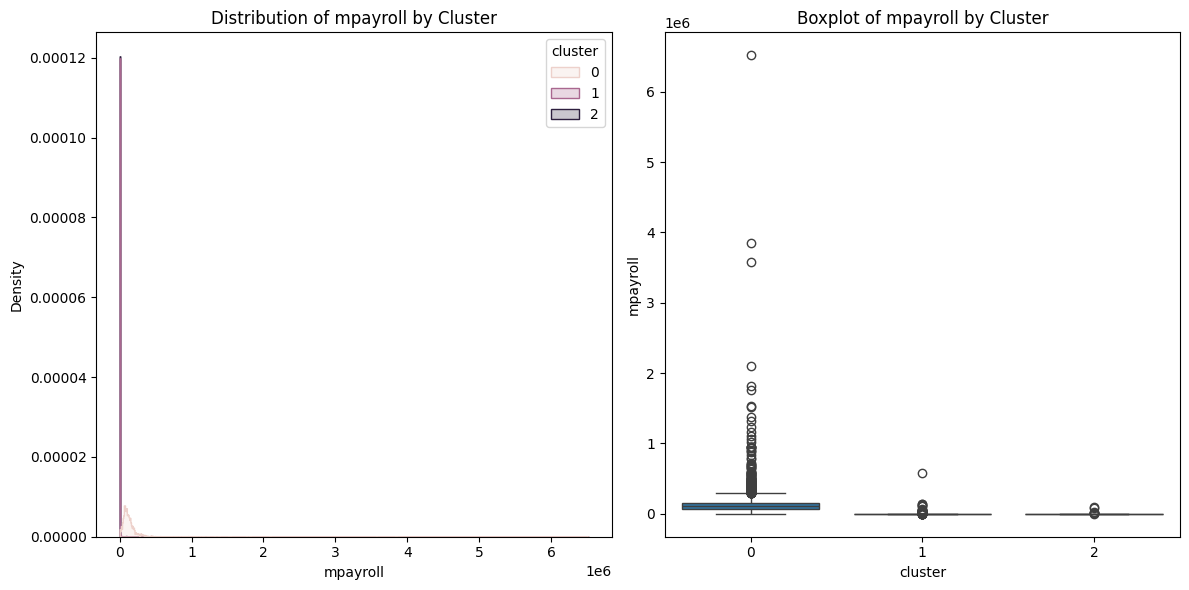

          count           mean            std  min       25%        50%  \
cluster                                                                   
0        2239.0  142960.195083  225771.054622  0.0  66708.65  104172.88   
1        3228.0     619.363736   11689.723030  0.0      0.00       0.00   
2         690.0     342.660029    5071.675292  0.0      0.00       0.00   

                75%         max  
cluster                          
0        156167.395  6517531.68  
1             0.000   581717.67  
2             0.000    97861.04  

Correlation with other top features:
mpayroll                         1.000000
cpayroll_trx                     0.346009
ctarjeta_debito_transacciones    0.215882
mcomisiones_mantenimiento       -0.219647
ccomisiones_mantenimiento       -0.270866
Name: mpayroll, dtype: float64

Feature: mcomisiones_mantenimiento


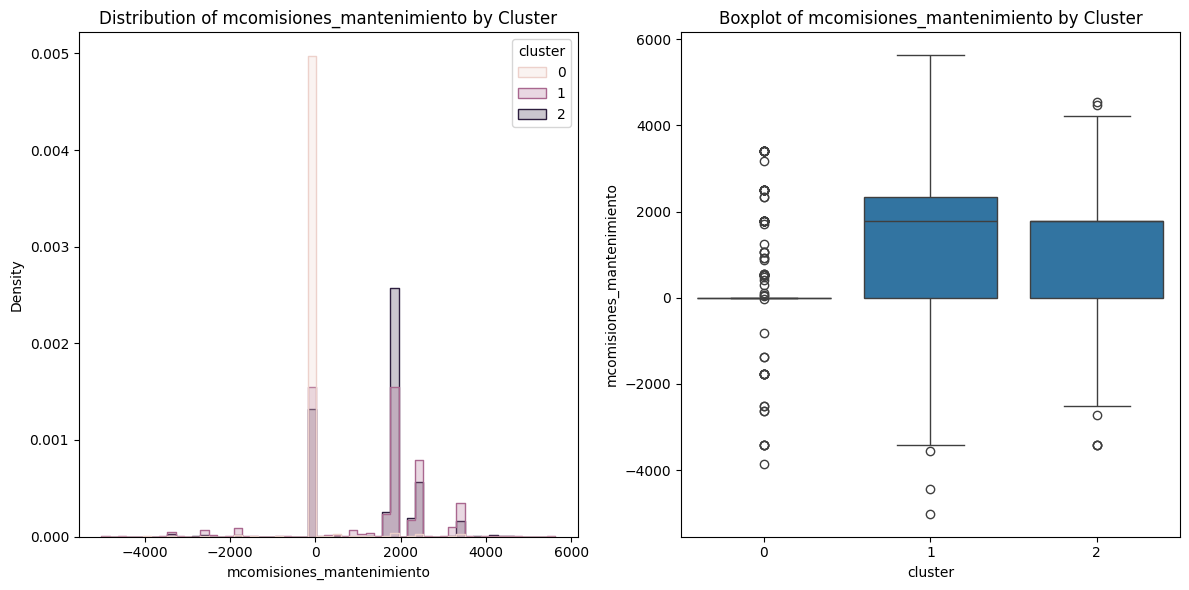

          count         mean          std      min  25%      50%      75%  \
cluster                                                                     
0        2239.0    35.172858   430.159775 -3856.35  0.0     0.00     0.00   
1        3228.0  1298.093944  1363.747118 -5011.90  0.0  1774.04  2328.21   
2         690.0  1428.995145  1059.792167 -3413.33  0.0  1774.04  1774.04   

             max  
cluster           
0        3413.33  
1        5630.30  
2        4545.18  

Correlation with other top features:
mcomisiones_mantenimiento        1.000000
ccomisiones_mantenimiento        0.660414
mpayroll                        -0.219647
ctarjeta_debito_transacciones   -0.235036
cpayroll_trx                    -0.332041
Name: mcomisiones_mantenimiento, dtype: float64

Feature: ccomisiones_mantenimiento


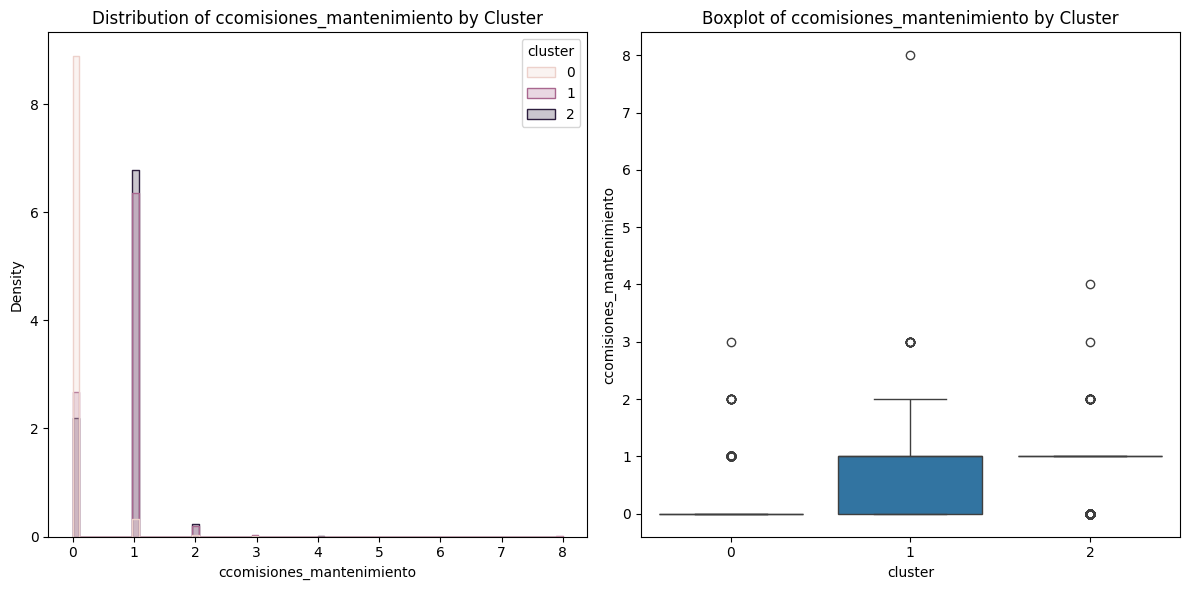

          count      mean       std  min  25%  50%  75%  max
cluster                                                     
0        2239.0  0.044216  0.228277  0.0  0.0  0.0  0.0  3.0
1        3228.0  0.740087  0.518912  0.0  0.0  1.0  1.0  8.0
2         690.0  0.795652  0.491121  0.0  1.0  1.0  1.0  4.0

Correlation with other top features:
ccomisiones_mantenimiento        1.000000
mcomisiones_mantenimiento        0.660414
mpayroll                        -0.270866
ctarjeta_debito_transacciones   -0.290828
cpayroll_trx                    -0.417859
Name: ccomisiones_mantenimiento, dtype: float64

Feature: ctarjeta_debito_transacciones


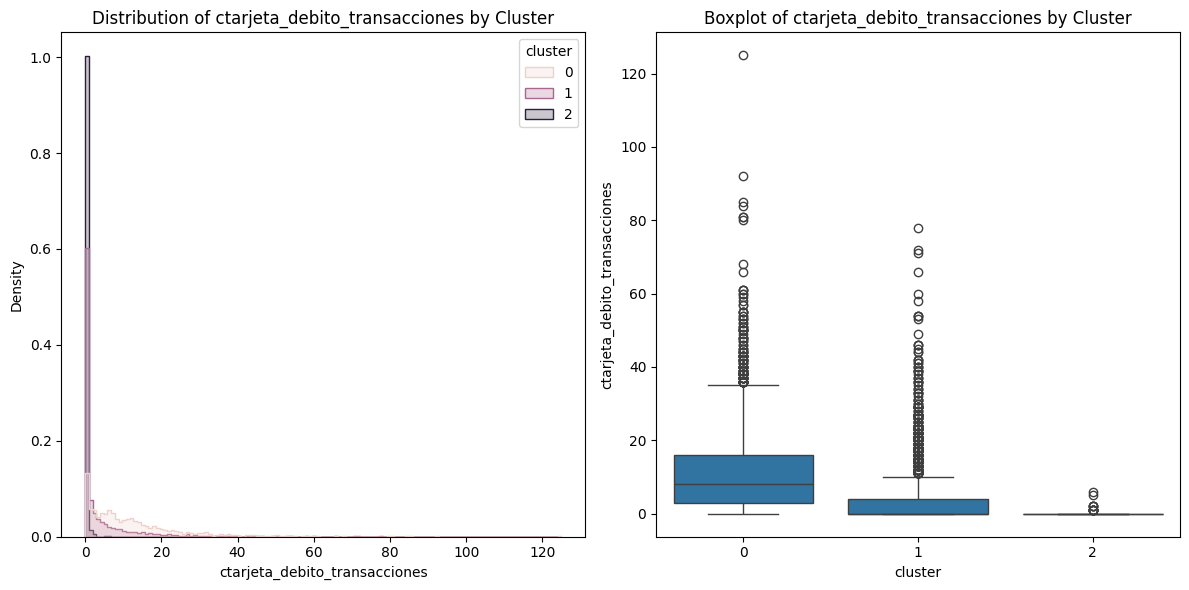

          count       mean        std  min  25%  50%   75%    max
cluster                                                          
0        2239.0  11.623493  12.245252  0.0  3.0  8.0  16.0  125.0
1        3228.0   3.578067   7.616695  0.0  0.0  0.0   4.0   78.0
2         690.0   0.040580   0.350955  0.0  0.0  0.0   0.0    6.0

Correlation with other top features:
ctarjeta_debito_transacciones    1.000000
cpayroll_trx                     0.288346
mpayroll                         0.215882
mcomisiones_mantenimiento       -0.235036
ccomisiones_mantenimiento       -0.290828
Name: ctarjeta_debito_transacciones, dtype: float64

Analysis for Cluster 1

Feature: mpayroll


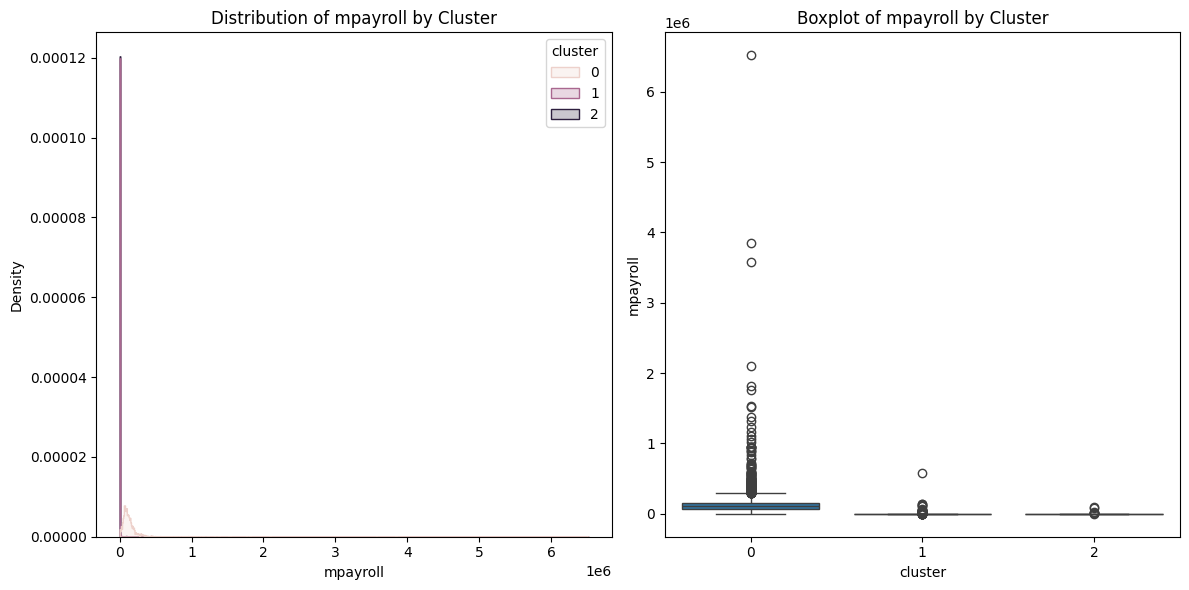

          count           mean            std  min       25%        50%  \
cluster                                                                   
0        2239.0  142960.195083  225771.054622  0.0  66708.65  104172.88   
1        3228.0     619.363736   11689.723030  0.0      0.00       0.00   
2         690.0     342.660029    5071.675292  0.0      0.00       0.00   

                75%         max  
cluster                          
0        156167.395  6517531.68  
1             0.000   581717.67  
2             0.000    97861.04  

Correlation with other top features:
mpayroll                     1.000000
cpayroll_trx                 0.346009
ctarjeta_visa                0.104904
mcomisiones_mantenimiento   -0.219647
ccomisiones_mantenimiento   -0.270866
Name: mpayroll, dtype: float64

Feature: cpayroll_trx


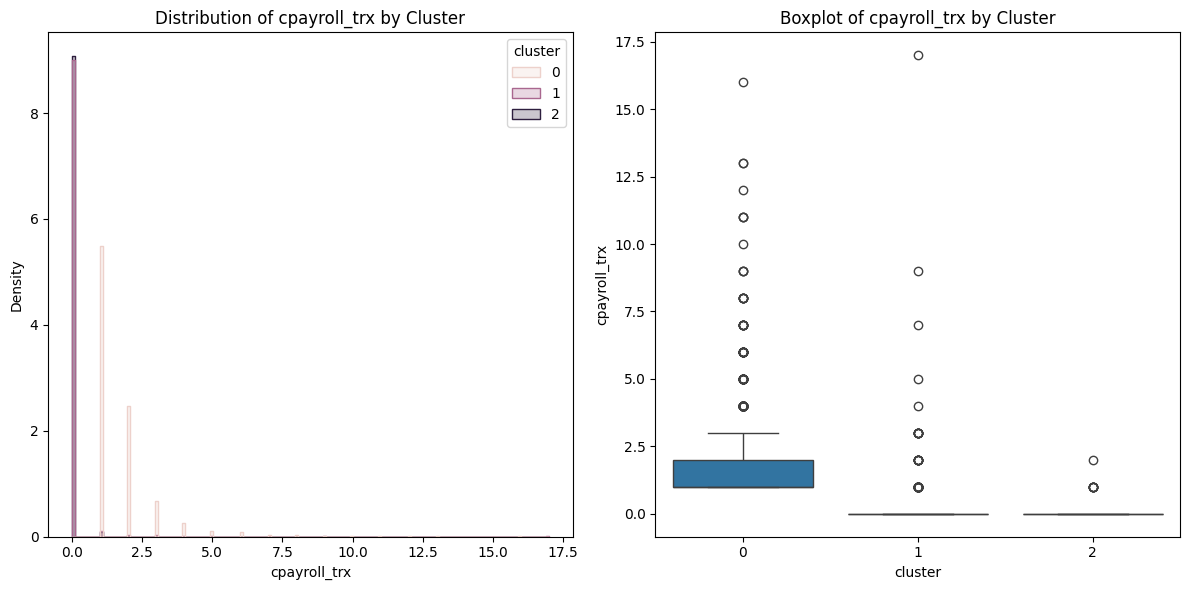

          count      mean       std  min  25%  50%  75%   max
cluster                                                      
0        2239.0  1.683341  1.249573  1.0  1.0  1.0  2.0  16.0
1        3228.0  0.037794  0.431696  0.0  0.0  0.0  0.0  17.0
2         690.0  0.013043  0.125677  0.0  0.0  0.0  0.0   2.0

Correlation with other top features:
cpayroll_trx                 1.000000
mpayroll                     0.346009
ctarjeta_visa                0.140041
mcomisiones_mantenimiento   -0.332041
ccomisiones_mantenimiento   -0.417859
Name: cpayroll_trx, dtype: float64

Feature: mcomisiones_mantenimiento


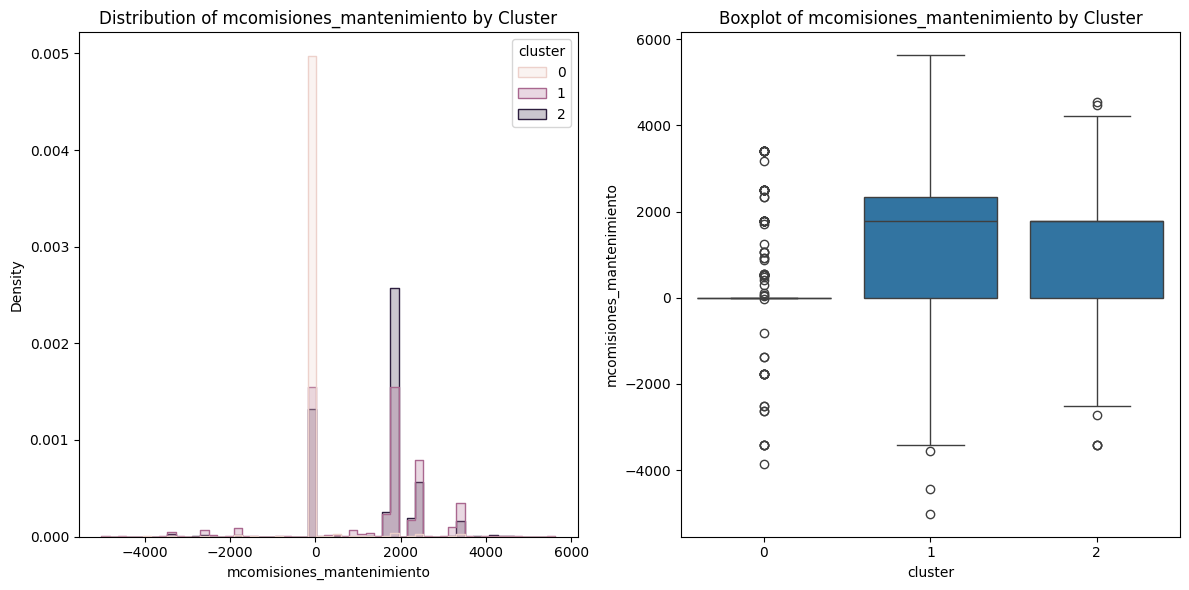

          count         mean          std      min  25%      50%      75%  \
cluster                                                                     
0        2239.0    35.172858   430.159775 -3856.35  0.0     0.00     0.00   
1        3228.0  1298.093944  1363.747118 -5011.90  0.0  1774.04  2328.21   
2         690.0  1428.995145  1059.792167 -3413.33  0.0  1774.04  1774.04   

             max  
cluster           
0        3413.33  
1        5630.30  
2        4545.18  

Correlation with other top features:
mcomisiones_mantenimiento    1.000000
ccomisiones_mantenimiento    0.660414
ctarjeta_visa               -0.119052
mpayroll                    -0.219647
cpayroll_trx                -0.332041
Name: mcomisiones_mantenimiento, dtype: float64

Feature: ctarjeta_visa


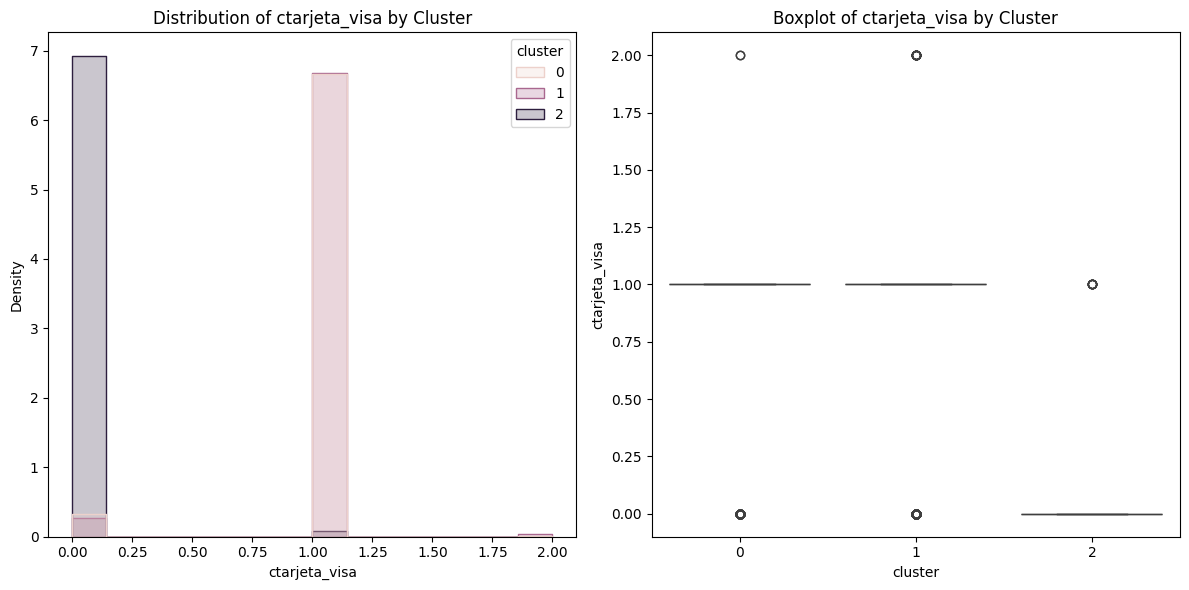

          count      mean       std  min  25%  50%  75%  max
cluster                                                     
0        2239.0  0.953997  0.213760  0.0  1.0  1.0  1.0  2.0
1        3228.0  0.966853  0.209366  0.0  1.0  1.0  1.0  2.0
2         690.0  0.011594  0.107128  0.0  0.0  0.0  0.0  1.0

Correlation with other top features:
ctarjeta_visa                1.000000
cpayroll_trx                 0.140041
mpayroll                     0.104904
mcomisiones_mantenimiento   -0.119052
ccomisiones_mantenimiento   -0.137215
Name: ctarjeta_visa, dtype: float64

Feature: ccomisiones_mantenimiento


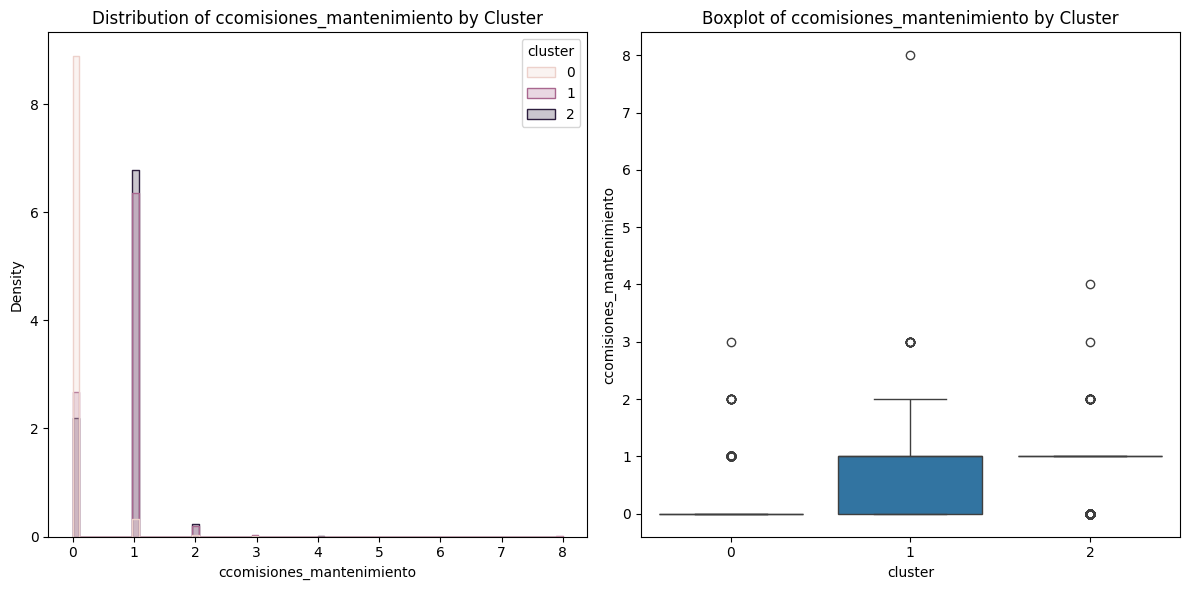

          count      mean       std  min  25%  50%  75%  max
cluster                                                     
0        2239.0  0.044216  0.228277  0.0  0.0  0.0  0.0  3.0
1        3228.0  0.740087  0.518912  0.0  0.0  1.0  1.0  8.0
2         690.0  0.795652  0.491121  0.0  1.0  1.0  1.0  4.0

Correlation with other top features:
ccomisiones_mantenimiento    1.000000
mcomisiones_mantenimiento    0.660414
ctarjeta_visa               -0.137215
mpayroll                    -0.270866
cpayroll_trx                -0.417859
Name: ccomisiones_mantenimiento, dtype: float64

Analysis for Cluster 2

Feature: ctarjeta_visa


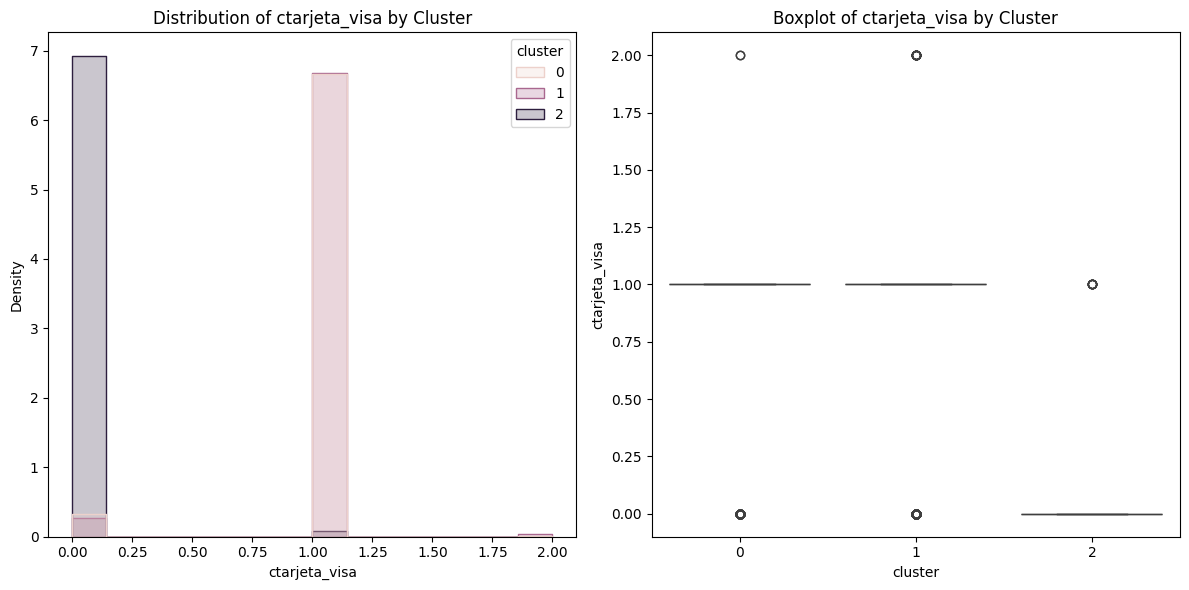

          count      mean       std  min  25%  50%  75%  max
cluster                                                     
0        2239.0  0.953997  0.213760  0.0  1.0  1.0  1.0  2.0
1        3228.0  0.966853  0.209366  0.0  1.0  1.0  1.0  2.0
2         690.0  0.011594  0.107128  0.0  0.0  0.0  0.0  1.0

Correlation with other top features:
ctarjeta_visa      1.000000
ctarjeta_master    0.729872
cproductos         0.555533
ctrx_quarter       0.290657
mcaja_ahorro       0.079069
Name: ctarjeta_visa, dtype: float64

Feature: cproductos


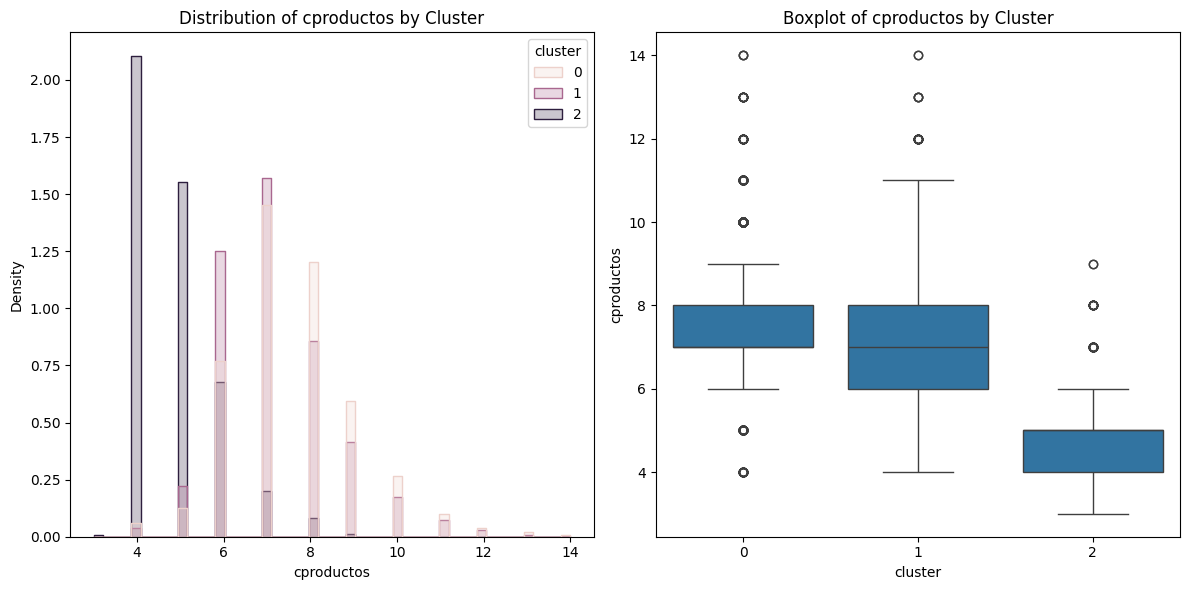

          count      mean       std  min  25%  50%  75%   max
cluster                                                      
0        2239.0  7.590442  1.453085  4.0  7.0  7.0  8.0  14.0
1        3228.0  7.192379  1.362603  4.0  6.0  7.0  8.0  14.0
2         690.0  4.840580  0.979073  3.0  4.0  5.0  5.0   9.0

Correlation with other top features:
cproductos         1.000000
ctarjeta_visa      0.555533
ctarjeta_master    0.549135
ctrx_quarter       0.396043
mcaja_ahorro       0.127307
Name: cproductos, dtype: float64

Feature: ctarjeta_master


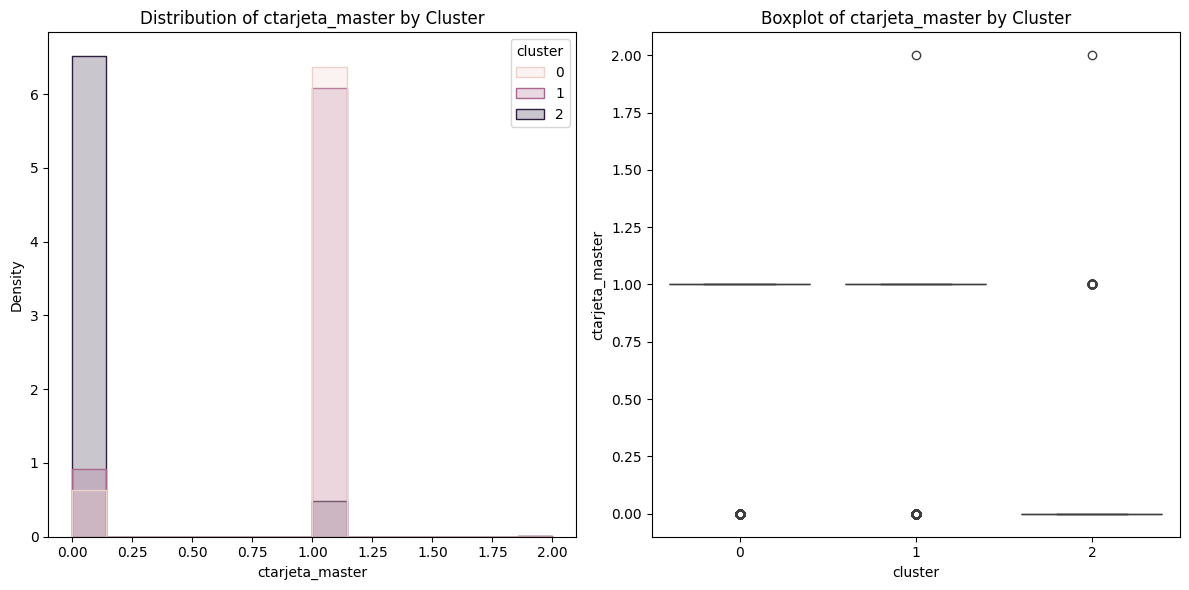

          count      mean       std  min  25%  50%  75%  max
cluster                                                     
0        2239.0  0.909781  0.286559  0.0  1.0  1.0  1.0  1.0
1        3228.0  0.869269  0.338076  0.0  1.0  1.0  1.0  2.0
2         690.0  0.071014  0.262621  0.0  0.0  0.0  0.0  2.0

Correlation with other top features:
ctarjeta_master    1.000000
ctarjeta_visa      0.729872
cproductos         0.549135
ctrx_quarter       0.277571
mcaja_ahorro       0.076246
Name: ctarjeta_master, dtype: float64

Feature: mcaja_ahorro


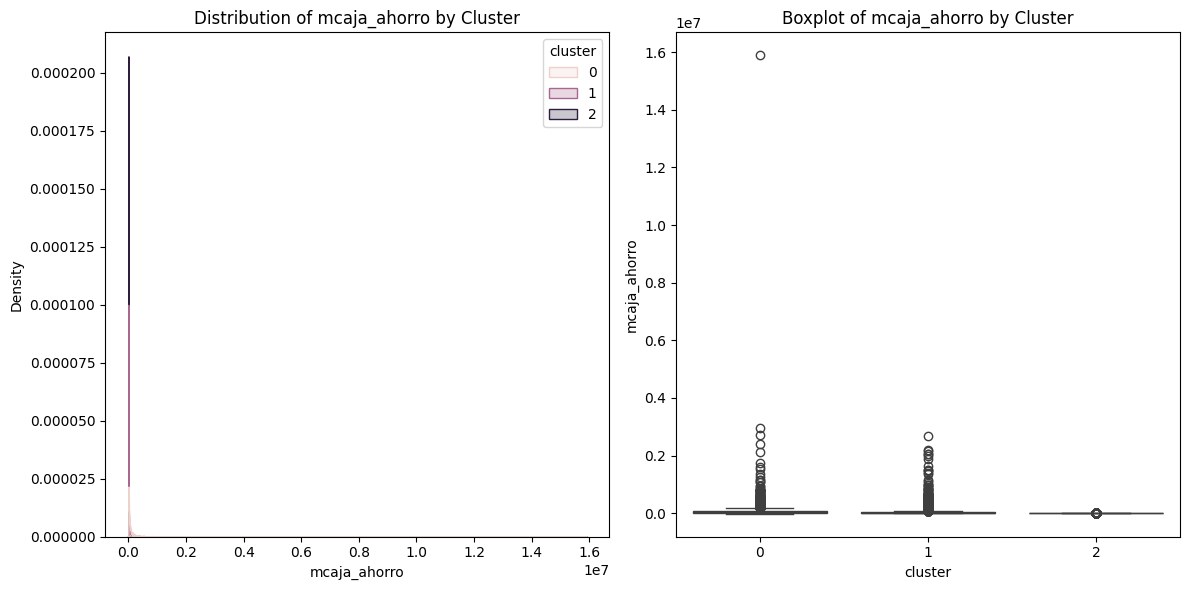

          count          mean            std       min        25%       50%  \
cluster                                                                       
0        2239.0  91840.761697  378683.507966 -15048.51  12063.095  32896.76   
1        3228.0  45453.307949  154832.470858   -755.64     71.625   4879.56   
2         690.0    210.065058     743.515454      0.00      0.000      0.00   

                75%          max  
cluster                           
0        82816.7750  15895921.58  
1        27645.1375   2694353.70  
2            0.0000      6956.17  

Correlation with other top features:
mcaja_ahorro       1.000000
ctrx_quarter       0.154917
cproductos         0.127307
ctarjeta_visa      0.079069
ctarjeta_master    0.076246
Name: mcaja_ahorro, dtype: float64

Feature: ctrx_quarter


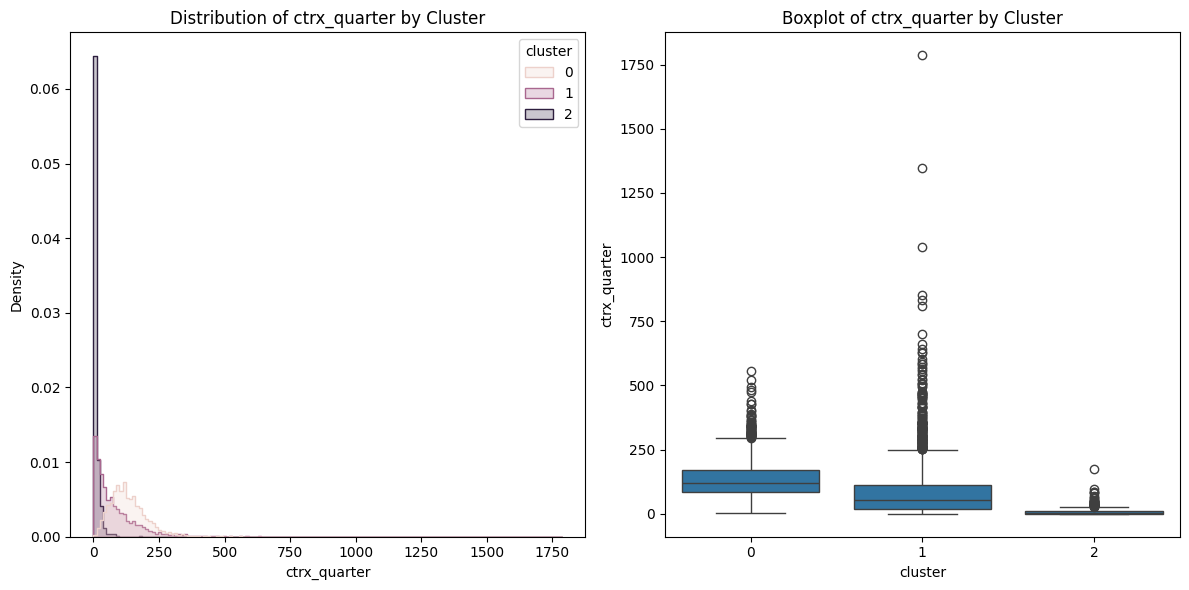

          count        mean         std  min   25%    50%     75%     max
cluster                                                                  
0        2239.0  131.969629   69.844779  2.0  84.0  120.0  169.00   558.0
1        3228.0   83.028191  100.410506  0.0  20.0   53.0  112.25  1786.0
2         690.0    8.398551   13.492642  0.0   0.0    4.0   11.00   176.0

Correlation with other top features:
ctrx_quarter       1.000000
cproductos         0.396043
ctarjeta_visa      0.290657
ctarjeta_master    0.277571
mcaja_ahorro       0.154917
Name: ctrx_quarter, dtype: float64

Analysis for Cluster -1

Feature: mpasivos_margen


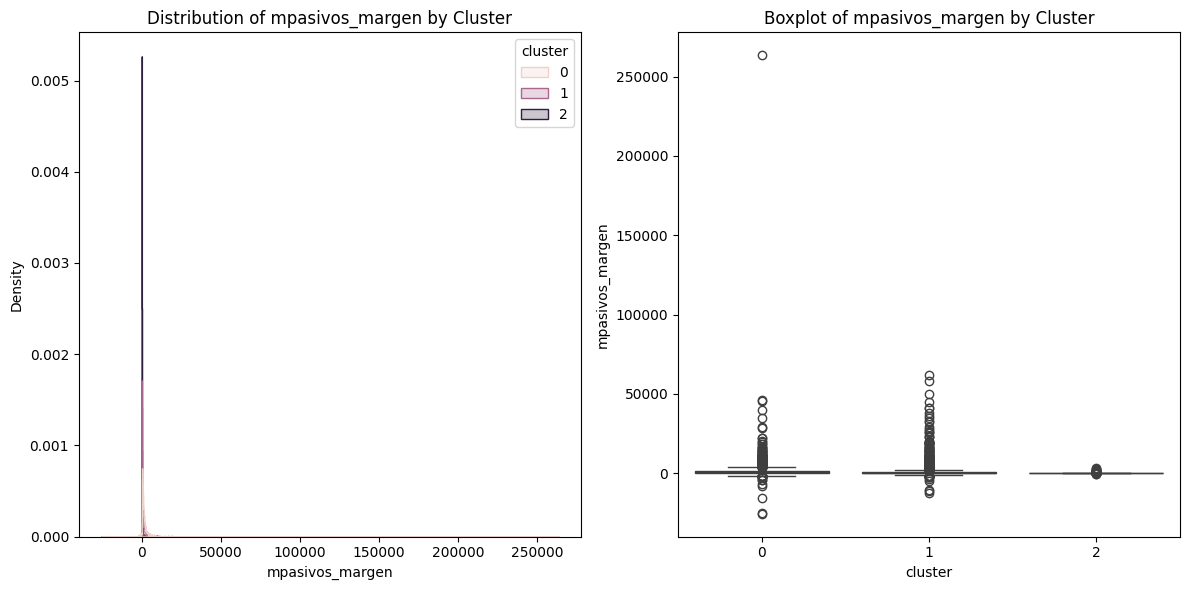

          count         mean          std       min       25%      50%  \
cluster                                                                  
0        2239.0  1626.753810  6348.684878 -25463.81  316.6750  737.280   
1        3228.0  1154.077227  3544.672907 -12642.26   36.7700  261.060   
2         690.0    77.137043   267.816509   -670.71    0.3625   11.345   

               75%        max  
cluster                        
0        1661.6950  263420.85  
1         936.2625   61661.32  
2          46.5150    3007.83  

Correlation with other top features:
mpasivos_margen        1.000000
mpagomiscuentas        0.729146
Visa_mconsumospesos    0.187594
Visa_Fvencimiento     -0.084570
Visa_mpagospesos      -0.153954
Name: mpasivos_margen, dtype: float64

Feature: Visa_mpagospesos


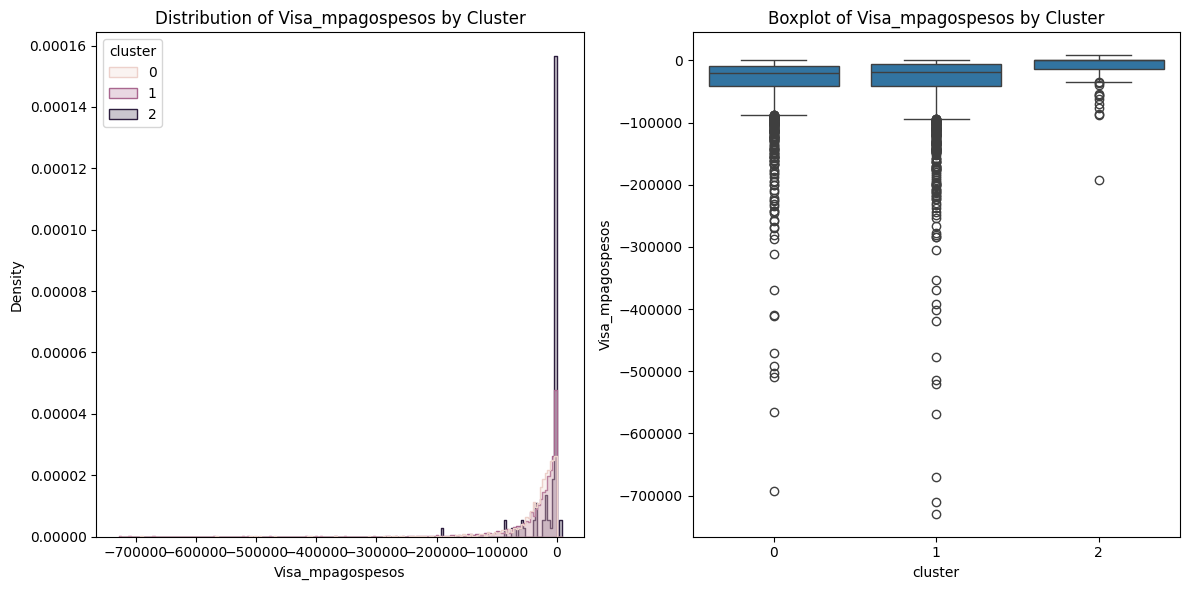

          count          mean           std        min         25%       50%  \
cluster                                                                        
0        1956.0 -34713.857551  49279.911771 -691786.99 -40841.0450 -21096.79   
1        2465.0 -33711.863984  52643.539678 -729010.06 -41128.3900 -17962.47   
2          92.0 -12799.536630  28111.613087 -192020.10 -13964.5425      0.00   

               75%      max  
cluster                      
0       -9801.6625     5.78  
1       -5900.3000     0.00  
2           0.0000  8211.00  

Correlation with other top features:
Visa_mpagospesos       1.000000
Visa_Fvencimiento     -0.019997
mpagomiscuentas       -0.020683
mpasivos_margen       -0.153954
Visa_mconsumospesos   -0.662252
Name: Visa_mpagospesos, dtype: float64

Feature: mpagomiscuentas


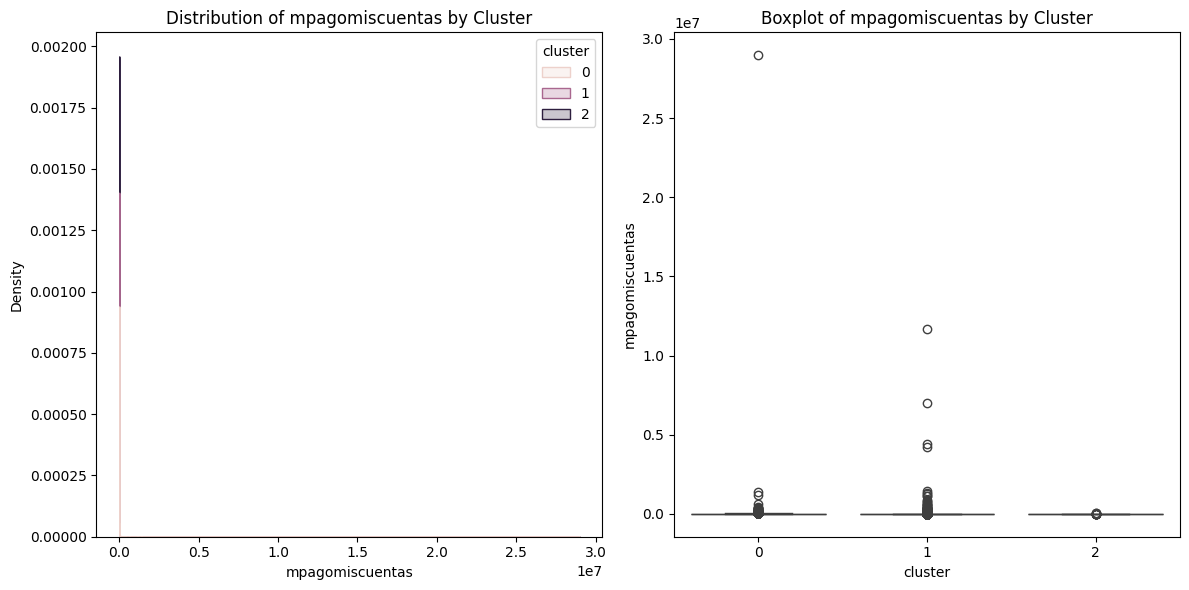

          count          mean            std  min  25%      50%       75%  \
cluster                                                                     
0        2239.0  24699.516731  613885.924576  0.0  0.0  1003.68  10188.04   
1        3228.0  21457.293364  270755.269072  0.0  0.0     0.00   2294.01   
2         690.0    172.404928    2106.837978  0.0  0.0     0.00      0.00   

                 max  
cluster               
0        28967445.40  
1        11694607.64  
2           42580.74  

Correlation with other top features:
mpagomiscuentas        1.000000
mpasivos_margen        0.729146
Visa_mconsumospesos    0.064294
Visa_mpagospesos      -0.020683
Visa_Fvencimiento     -0.061042
Name: mpagomiscuentas, dtype: float64

Feature: Visa_Fvencimiento


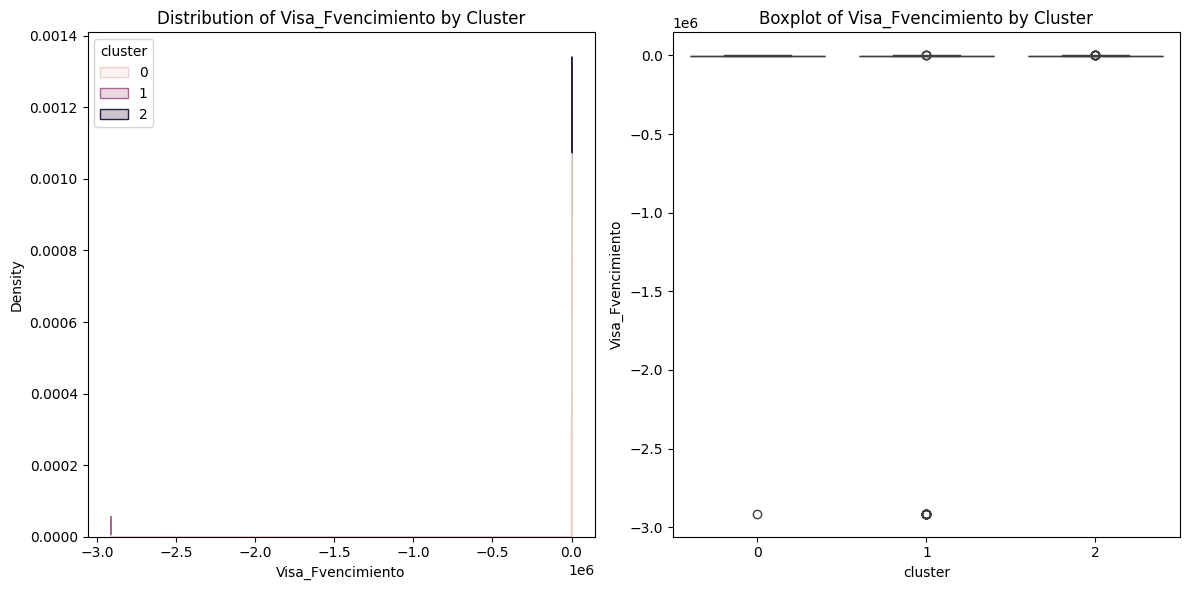

          count          mean            std        min     25%     50%  \
cluster                                                                   
0        2137.0  -2663.915770   63013.249370 -2914148.0 -1705.0 -1430.0   
1        3136.0 -17047.817283  213919.794705 -2914148.0 -1705.0 -1309.0   
2         127.0  -1356.354331     515.704042    -2221.0 -1705.0 -1460.0   

            75%     max  
cluster                  
0        -882.0   -60.0  
1        -852.0  1127.0  
2       -1110.5   -60.0  

Correlation with other top features:
Visa_Fvencimiento      1.000000
Visa_mconsumospesos   -0.000083
Visa_mpagospesos      -0.019997
mpagomiscuentas       -0.061042
mpasivos_margen       -0.084570
Name: Visa_Fvencimiento, dtype: float64

Feature: Visa_mconsumospesos


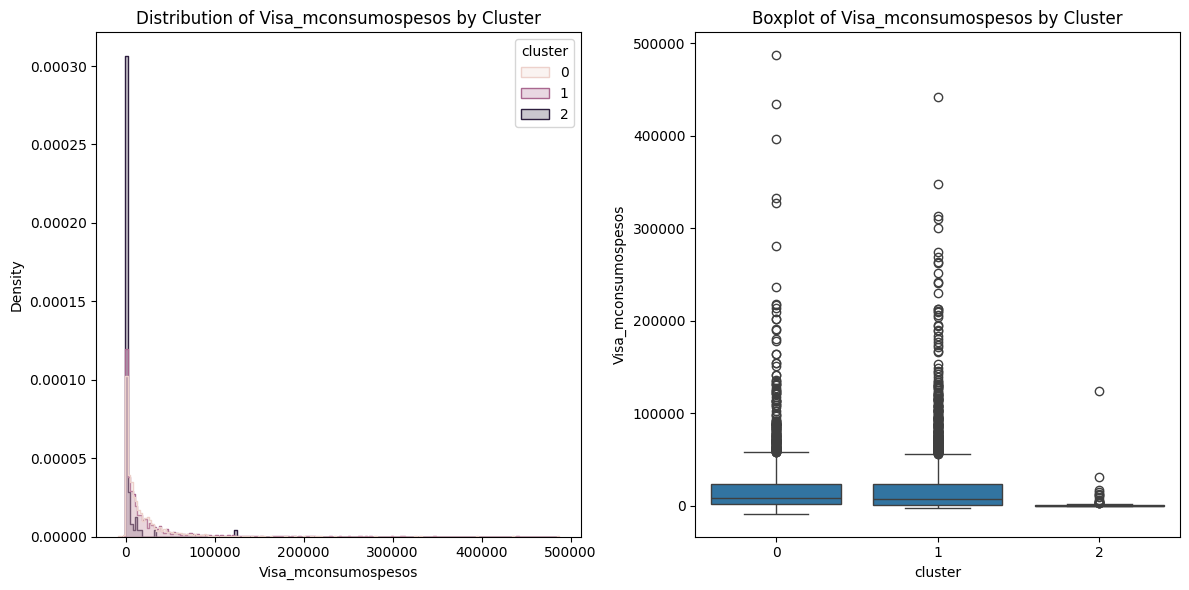

          count          mean           std      min       25%       50%  \
cluster                                                                    
0        1956.0  19603.378318  34114.558231 -8300.96  1787.775  8630.345   
1        2465.0  19947.338600  34998.829618 -2699.07  1286.930  7654.280   
2          92.0   3142.707826  13576.986547     0.00     0.000     0.000   

                75%        max  
cluster                         
0        24231.0725  486923.80  
1        23276.2100  441476.12  
2         1078.2000  124153.34  

Correlation with other top features:
Visa_mconsumospesos    1.000000
mpasivos_margen        0.187594
mpagomiscuentas        0.064294
Visa_Fvencimiento     -0.000083
Visa_mpagospesos      -0.662252
Name: Visa_mconsumospesos, dtype: float64


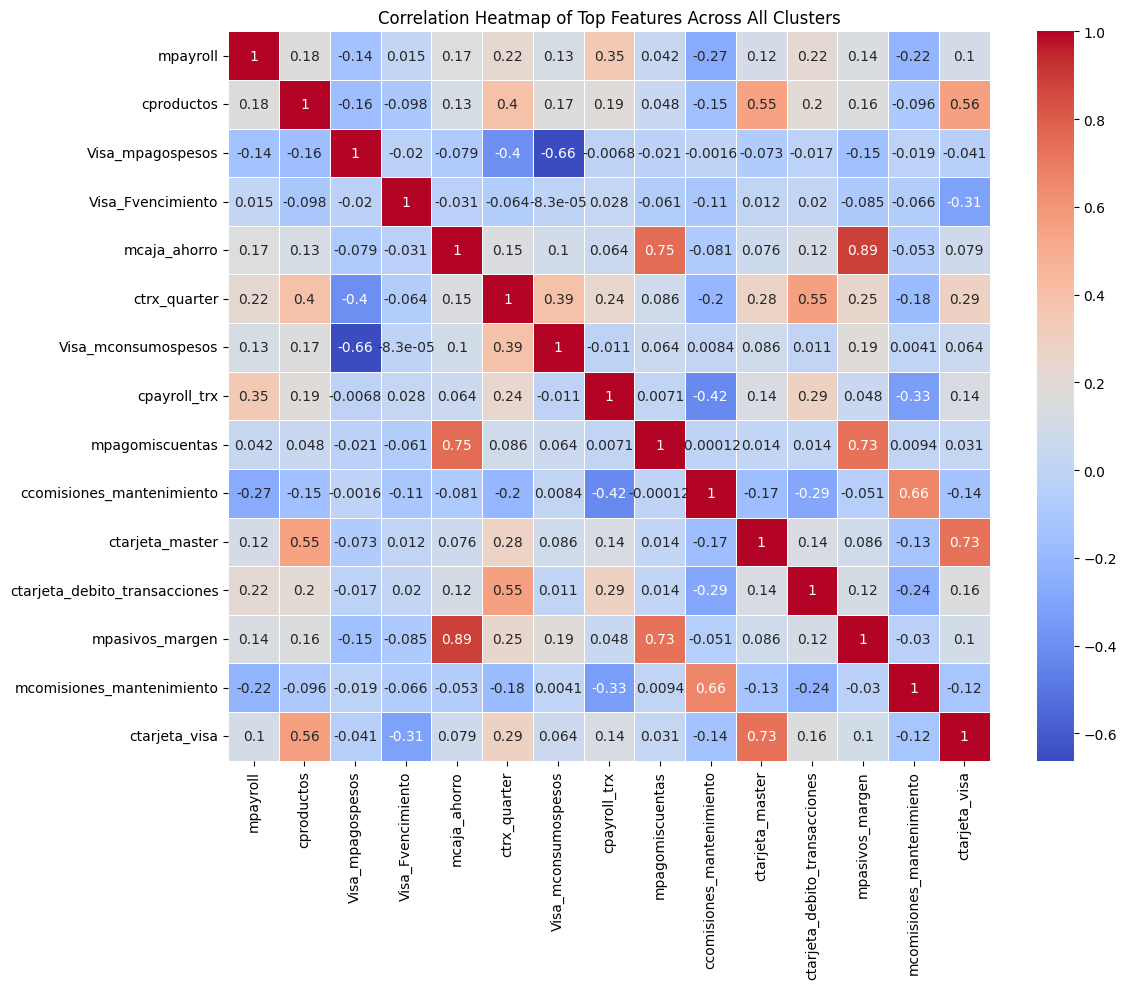

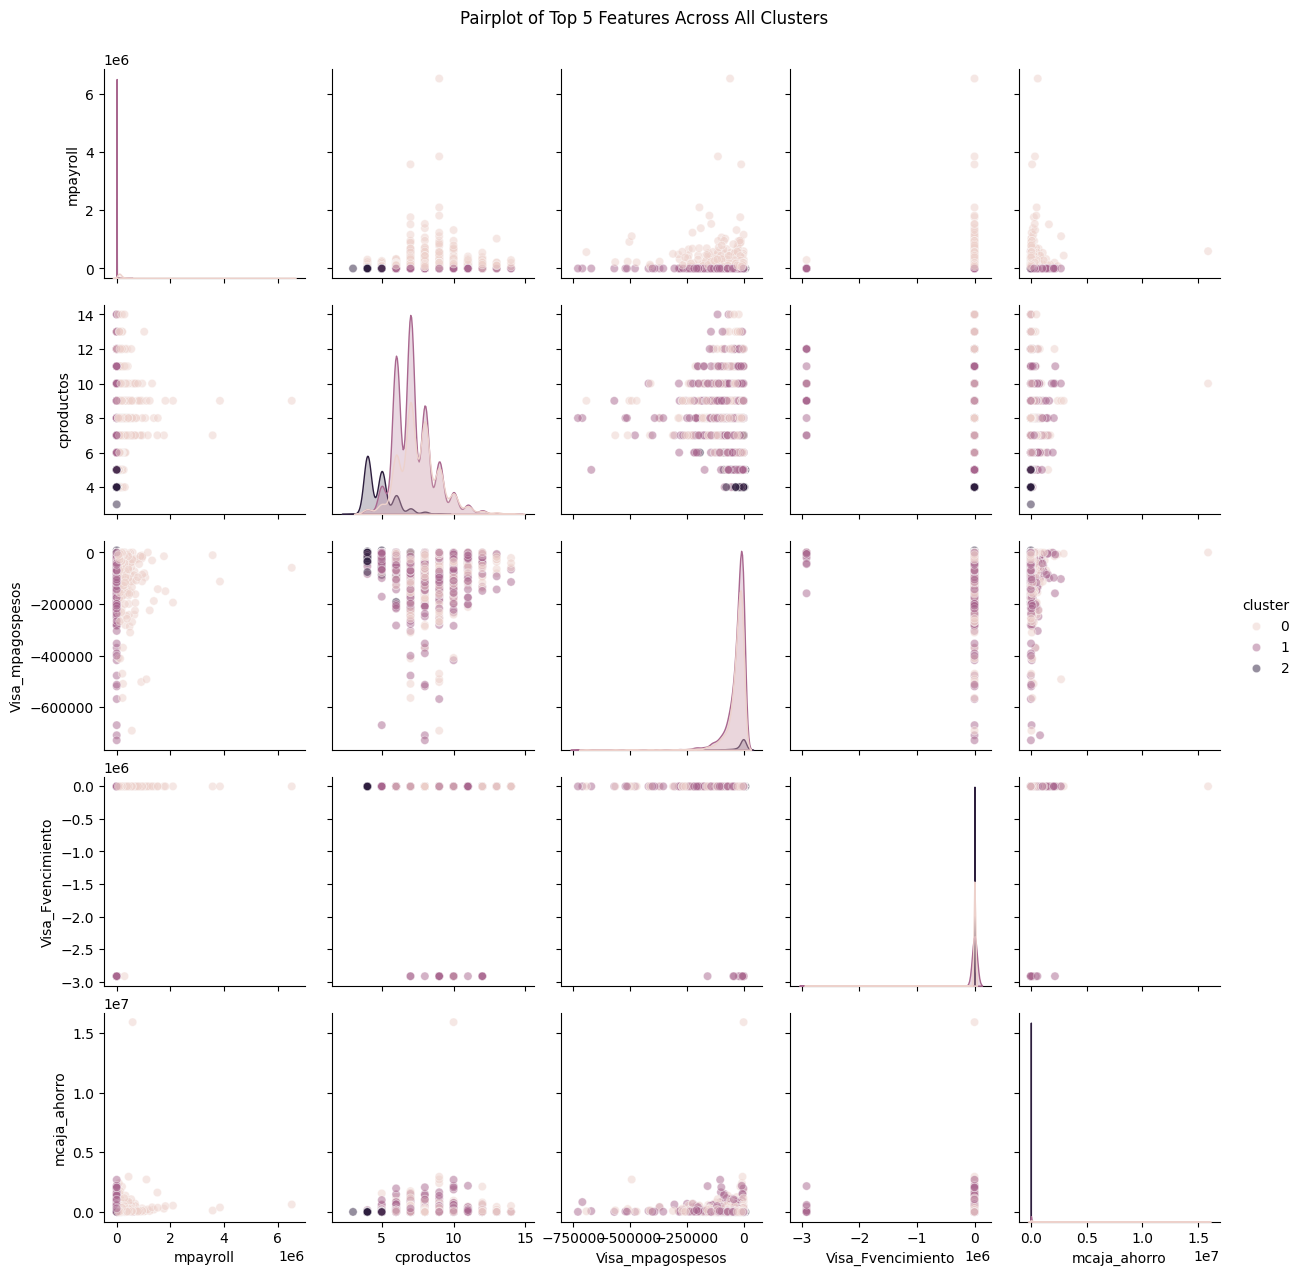

In [19]:

# Function to plot feature distributions
def plot_feature_distribution(feature, cluster, df):
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature, hue='cluster', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Cluster')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='cluster', y=feature)
    plt.title(f'Boxplot of {feature} by Cluster')
    
    plt.tight_layout()
    plt.show()

# Function to create summary statistics
def create_summary_stats(feature, df):
    return df.groupby('cluster')[feature].describe()

# Combine the embedding dataframe with the original features
df_analysis = pd.concat([df_embedding, Xtrain_rf.reset_index(drop=True)], axis=1)
df_analysis = df_analysis[df_analysis['cluster'] != -1]

# Analyze each cluster
for cluster, features in important_features_by_cluster.items():
    print(f"\nAnalysis for Cluster {cluster}")
    
    for feature in features[:5]:  # Analyze top 5 features for each cluster
        print(f"\nFeature: {feature}")
        
        # Plot distribution
        plot_feature_distribution(feature, cluster, df_analysis)
        
        # Print summary statistics
        print(create_summary_stats(feature, df_analysis))
        
        # Calculate and print correlation with other top features
        corr_features = [f for f in features[:5] if f != feature]
        corr_matrix = df_analysis[corr_features + [feature]].corr()[feature].sort_values(ascending=False)
        print("\nCorrelation with other top features:")
        print(corr_matrix)

# Create a heatmap of correlations between top features across all clusters
top_features = list(set([feature for features in important_features_by_cluster.values() for feature in features[:5]]))
correlation_matrix = df_analysis[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Top Features Across All Clusters')
plt.tight_layout()
plt.show()

# Create a pairplot for the top features
sns.pairplot(df_analysis, vars=top_features[:5], hue='cluster', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Top 5 Features Across All Clusters', y=1.02)
plt.show()